In [2]:
!pip install split-folders
!pip install torch-summary

In [81]:
import warnings     
warnings.filterwarnings('ignore')
import pathlib                                                                      
import numpy as np    
import pandas as pd
import matplotlib.pyplot as plt                  
import seaborn as sns  
import os       
import random
import splitfolders                               
from termcolor import colored                     

from tensorflow import keras 
import torch                  
import torch.nn as nn          # To work with Neural Networks
import torchvision 
import torch.nn.functional as F
import torch.utils.data

import torchvision.transforms as transforms  
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.io import read_image # For visualization
from torchvision.datasets import ImageFolder

In [82]:
data_folder = '../../data/RiceImagesDataset'

In [83]:
rice_classes = os.listdir(data_folder)
rice_classes

['Basmati',
 'Jasmine',
 'Ipsala',
 'Karacadag',
 'Rice_Citation_Request.txt',
 'Arborio']

In [84]:
rice_classes.remove('Rice_Citation_Request.txt')
num_classes = len(rice_classes) # Get number of classes
print(f'There are {num_classes} class: ', rice_classes)

There are 5 class:  ['Basmati', 'Jasmine', 'Ipsala', 'Karacadag', 'Arborio']


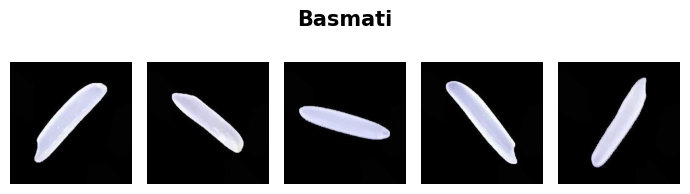

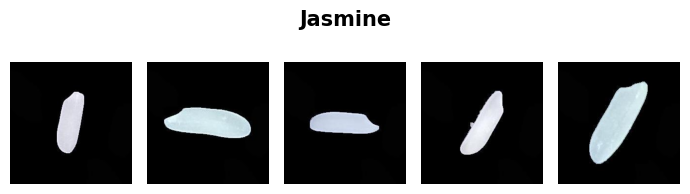

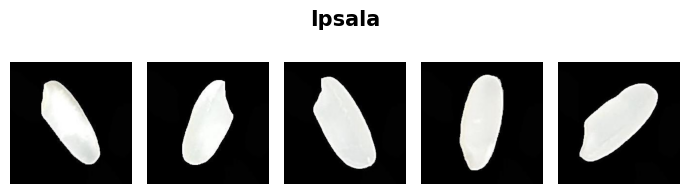

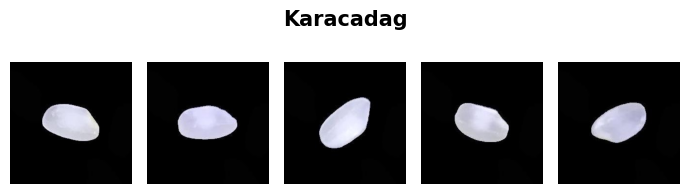

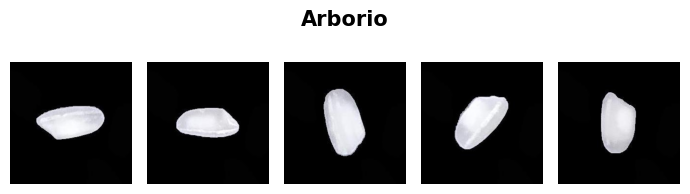

In [85]:
# 每一类随机选 5 张图片呈现
for class_name in rice_classes:
    class_path = os.path.join(data_folder, class_name)

    images = os.listdir(class_path)

    random_images = random.choices(images, k=5)
    fig, ax = plt.subplots(1, 5, figsize=(7, 2)) #1 row and 5 columns

    for i in range(5):
        plt.suptitle(class_name, fontsize=15, fontweight='bold')

        img_path = os.path.join(class_path, random_images[i])

        img = read_image(img_path)  
        img = transforms.ToPILImage()(img) 

        ax[i].imshow(img)
        ax[i].axis('off')  

    plt.tight_layout()  
    plt.show() 

In [86]:
# Splitting the data into three folders
# 这段代码的目的是将 data_folder 中的数据按照 0.75:0.15:0.1 的比例拆分成三个文件夹：
# 一个用于训练（75%）、一个用于验证（15%）和一个用于测试（10%）。
splitfolders.ratio(data_folder, output='data_splitted' , seed=42, ratio=(0.75, 0.15, 0.1))

In [92]:
new1_dir = './data_splitted'
new1_dir = pathlib.Path(new1_dir)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
transform = transforms.Compose([
        transforms.Resize((250,250)) ,
        transforms.ToTensor() ,
        transforms.Normalize((0),(1))])
Batch = 32
# ImageFolder 数据集对象 train_set，它会从 new1_dir.joinpath("train") 目录中读取图像，并且应用预处理操作 transform
train_set = ImageFolder(new1_dir.joinpath("train"), transform=transform)
# DataLoader 对象 train_loader，它负责按批次从 train_set 数据集中加载数据。每个批次的大小由 Batch 确定，并且每次训练时数据都会被打乱。
train_loader = DataLoader(train_set, batch_size=Batch, shuffle=True)

print(colored(f'Train Folder:\n{train_set}\n *******************************************************',
              'blue', attrs=['bold']))

val_set = ImageFolder(new1_dir.joinpath("val"), transform=transform)
val_loader = DataLoader(val_set, batch_size=Batch, shuffle = False)

print(colored(f'Validation Folder:\n{val_set}\n *******************************************************',
              'blue', attrs=['bold']))

test_set = ImageFolder(new1_dir.joinpath("test"), transform=transform)
test_loader = DataLoader(test_set, batch_size=Batch, shuffle = False)

print(colored(f'Test Folder:\n{test_set}\n *******************************************************',
              'blue', attrs=['bold']))

Train Folder:
Dataset ImageFolder
    Number of datapoints: 56250
    Root location: data_splitted/train
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=0, std=1)
           )
 *******************************************************
Validation Folder:
Dataset ImageFolder
    Number of datapoints: 11250
    Root location: data_splitted/val
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=0, std=1)
           )
 *******************************************************
Test Folder:
Dataset ImageFolder
    Number of datapoints: 7500
    Root location: data_splitted/test
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=True)
     

In [94]:
def print_loader_shapes(loaders):
    for key, value in loaders.items():
        X, y = next(iter(value))  # Get the first batch
        print(colored(f'{key}:', 'green', attrs=['bold']))
        print(f"Images shape: {X.shape}")
        print(f"Labels shape: {y.shape} {y.dtype}\n")
        print('*****************************************')
        
loaders = {'Train': train_loader, 'Validation': val_loader, 'Test': test_loader}
print_loader_shapes(loaders)

Train:
Images shape: torch.Size([32, 3, 250, 250])
Labels shape: torch.Size([32]) torch.int64

*****************************************
Validation:
Images shape: torch.Size([32, 3, 250, 250])
Labels shape: torch.Size([32]) torch.int64

*****************************************
Test:
Images shape: torch.Size([32, 3, 250, 250])
Labels shape: torch.Size([32]) torch.int64

*****************************************


In [95]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 62 * 62, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 62 * 62)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN(num_classes = 5)
summary(model, (3, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 250, 250]        896
├─MaxPool2d: 1-2                         [-1, 32, 125, 125]        --
├─Conv2d: 1-3                            [-1, 64, 125, 125]        18,496
├─MaxPool2d: 1-4                         [-1, 64, 62, 62]          --
├─Linear: 1-5                            [-1, 120]                 29,522,040
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 5]                   425
Total params: 29,552,021
Trainable params: 29,552,021
Non-trainable params: 0
Total mult-adds (M): 371.53
Input size (MB): 0.72
Forward/backward pass size (MB): 22.89
Params size (MB): 112.73
Estimated Total Size (MB): 136.34


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 250, 250]        896
├─MaxPool2d: 1-2                         [-1, 32, 125, 125]        --
├─Conv2d: 1-3                            [-1, 64, 125, 125]        18,496
├─MaxPool2d: 1-4                         [-1, 64, 62, 62]          --
├─Linear: 1-5                            [-1, 120]                 29,522,040
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 5]                   425
Total params: 29,552,021
Trainable params: 29,552,021
Non-trainable params: 0
Total mult-adds (M): 371.53
Input size (MB): 0.72
Forward/backward pass size (MB): 22.89
Params size (MB): 112.73
Estimated Total Size (MB): 136.34

In [96]:
model = CNN(num_classes).to(device)

In [97]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [99]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Initialize lists to keep track of metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()               # Zero the parameter gradients
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        
        # Store training metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval() 
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():  # Disable gradient calculation for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total
        
        # Store validation metrics
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch statistics
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    metrics_df = pd.DataFrame({
        'Epoch': range(1, num_epochs + 1),
        'Train Loss': train_losses,
        'Train Accuracy': train_accuracies,
        'Val Loss': val_losses,
        'Val Accuracy': val_accuracies
    })
    
    return metrics_df

In [100]:
metrics_df = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.1369, Train Accuracy: 0.9507, Val Loss: 0.0872, Val Accuracy: 0.9700
Epoch [2/10], Train Loss: 0.0721, Train Accuracy: 0.9758, Val Loss: 0.0375, Val Accuracy: 0.9875
Epoch [3/10], Train Loss: 0.0350, Train Accuracy: 0.9886, Val Loss: 0.0531, Val Accuracy: 0.9827
Epoch [4/10], Train Loss: 0.0285, Train Accuracy: 0.9905, Val Loss: 0.0326, Val Accuracy: 0.9908
Epoch [5/10], Train Loss: 0.0202, Train Accuracy: 0.9930, Val Loss: 0.0221, Val Accuracy: 0.9928
Epoch [6/10], Train Loss: 0.0161, Train Accuracy: 0.9948, Val Loss: 0.0198, Val Accuracy: 0.9937
Epoch [7/10], Train Loss: 0.0146, Train Accuracy: 0.9955, Val Loss: 0.0332, Val Accuracy: 0.9915
Epoch [8/10], Train Loss: 0.0120, Train Accuracy: 0.9962, Val Loss: 0.0295, Val Accuracy: 0.9924
Epoch [9/10], Train Loss: 0.0104, Train Accuracy: 0.9967, Val Loss: 0.0320, Val Accuracy: 0.9914
Epoch [10/10], Train Loss: 0.0082, Train Accuracy: 0.9972, Val Loss: 0.0797, Val Accuracy: 0.9824


In [101]:
metrics_df

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
0,1,0.136916,0.950738,0.087194,0.970044
1,2,0.072139,0.975804,0.037495,0.987467
2,3,0.034981,0.988640,0.053088,0.982667
3,4,0.028507,0.990524,0.032576,0.990844
4,5,0.020218,0.992996,0.022084,0.992800
5,6,0.016080,0.994844,0.019812,0.993689
6,7,0.014570,0.995467,0.033173,0.991467
7,8,0.012030,0.996249,0.029511,0.992444
8,9,0.010399,0.996658,0.032021,0.991378
9,10,0.008186,0.997244,0.079721,0.982400


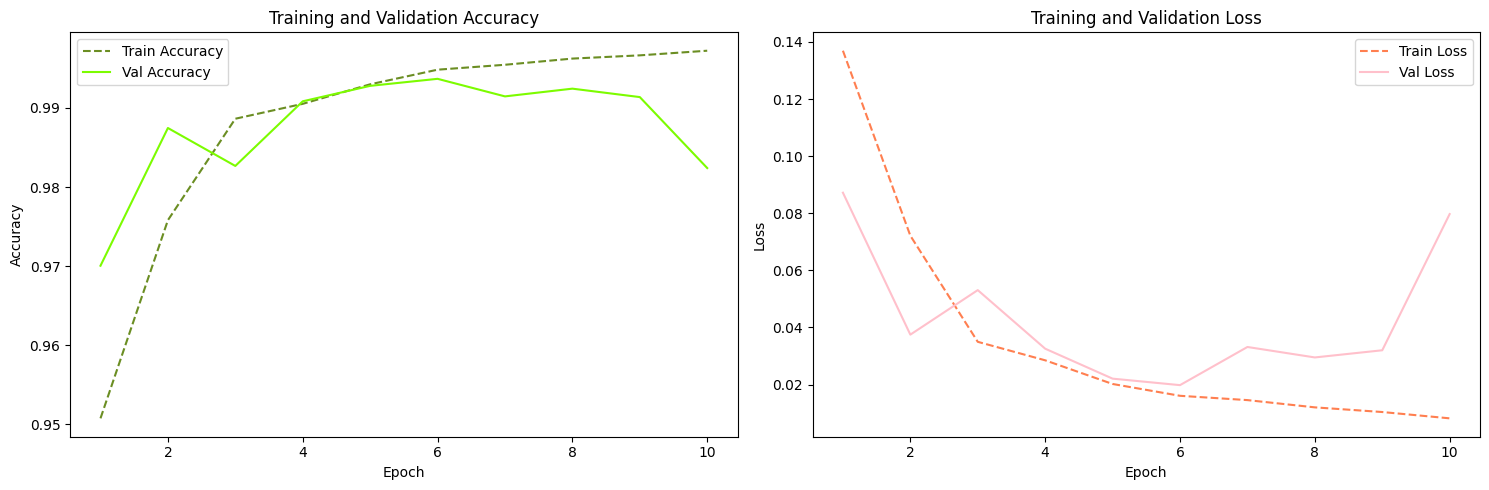

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axs[0].plot(metrics_df['Epoch'], metrics_df['Train Accuracy'],'--r',color='olivedrab', label='Train Accuracy')
axs[0].plot(metrics_df['Epoch'], metrics_df['Val Accuracy'],color = 'lawngreen', label='Val Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
    
# Plot loss
axs[1].plot(metrics_df['Epoch'], metrics_df['Train Loss'],'--r',color = 'coral', label='Train Loss')
axs[1].plot(metrics_df['Epoch'], metrics_df['Val Loss'],color = 'pink', label='Val Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()